In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import pickle
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [3]:
# select units
def select_unit_qc_region_mouse_session(all_unit_qc, region_annotation="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region_annotation)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)
    

# fetch keys
def gen_keys2units(unit_qc_region_mouse_session):
    # get all keys
    keys2units = unit_qc_region_mouse_session.fetch('KEY')
    print('num of units: {}'.format(len(keys2units)))

    return keys2units

In [4]:
# fetch data from brain region
region_ann_lut = {
    # premotor
    'ALM': "Secondary motor area%",
    # isocortex, PFC
    'PL': "Prelimbic%",
    'ACA': "Anterior cingulate area%",
    'ILA': "Infralimbic%",
    'ORB': '%orbital%',
    'FRP': '%frontal%',
    'RSP': "Retrosplenial area%",
    # thalamus
    'VM': 'Ventral medial%',
    'MD': 'Mediodorsal%',
    # striatum
    'LSN': "Lateral septal nucleus%",
    'CP': "Caudoputamen%",
    'NA': "Nucleus accumbens%",
    'striatum': "striatum%",
    # Pallidum
    'PALv': "Substantia innominata%",
    # Olfactory
    'OLF': "%olfactory%",
}

In [5]:
# fetch unit data
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:]

,count
annotation,
"Lateral septal nucleus, rostral (rostroventral) part",801
Caudoputamen,473
"Secondary motor area, layer 6a",401
"Secondary motor area, layer 5",294
"Prelimbic area, layer 5",286
...,...
Ethmoid nucleus of the thalamus,1
"Retrosplenial area, ventral part, layer 6a",1
Triangular nucleus of septum,1


In [10]:
# fetch and organize data

period = 'iti_all'
# periods: experiment.PeriodForaging

model_id = 10

# use only latter sessions
latter_session = 30

regions = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
mouses = {
    'ALM': 'HH13', #sess=4
    'PL': 'HH08', #sess=4
    'ACA': 'HH13', #sess=5
    'ORB': 'HH09', #sess=4
    'LSN': 'HH13', #sess=6
    'striatum': 'HH08', #sess=5
    'MD': 'HH09' #sess=4
}

neuron_columns = ['session', 'unit', 'firing_rates']
neurons = {region: pd.DataFrame(columns=neuron_columns) for region in regions}

q_latent_columns = ['session', 'Q_left', 'Q_right']
q_latents = {region: None for region in regions}


for region in regions:
    mouse = mouses[region]
    subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]
    print(f'region: {region}')
    
    # get fitted latent variables
    q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & 
                         {'model_id': model_id, 'subject_id': subject_id})
    df_Q = pd.DataFrame(q_latent_variable.fetch())
    df_Q_left = df_Q[df_Q['water_port']=='left'][['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
    df_Q_right = df_Q[df_Q['water_port']=='right'][['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
    df_Qs = df_Q_left.merge(df_Q_right)
    q_latents[region] = df_Qs

    sessions_all = np.unique(df_Qs['session'].values)
    sessions = sessions_all[sessions_all > latter_session]


    for session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==session]
        ## check if Q_left or Q_right are missing
        if np.isnan(df_Qs_session['Q_left'].values).any() or np.isnan(df_Qs_session['Q_right'].values).any():
            Q_left_nan = np.where(np.isnan(df_Qs_session['Q_left'].values))[0]
            Q_right_nan = np.where(np.isnan(df_Qs_session['Q_right'].values))[0]
            print(f' nan present in Qs: region {region}, sess {session}, left {Q_left_nan}, right {Q_right_nan}')
            print(' dropping nan')
            df_Qs_session.dropna(subset=['Q_left', 'Q_right'], inplace=True)

        unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(
                                            all_unit_qc, 
                                            region_annotation=region_ann_lut[region], 
                                            mouse=mouse, 
                                            session=session)
        if len(unit_qc_region_mouse_session) > 0:
            print(f'total number of units in {region} in sess {session}: {len(unit_qc_region_mouse_session)}')
            # fetch keys
            keys2units = gen_keys2units(unit_qc_region_mouse_session)

            trials_q = df_Qs_session['trial'].values
            # get unit activity
            for unit_key in keys2units:
                unit = unit_key['unit']
                
                period_activity = psth_foraging.compute_unit_period_activity(unit_key, period)
                trials_unit = period_activity['trial']

                # correct mismatch trials from q and unit
                trials_q_not_in_unit = trials_q[~np.isin(trials_q, trials_unit)]
                if np.any(trials_q_not_in_unit):
                    print(f' mismatch: {region} {session}, trials_q_not_in_unit: {trials_q_not_in_unit}')
                    for t in trials_q_not_in_unit:
                        df_Qs_session.drop(df_Qs_session[df_Qs_session['trial']==t].index, inplace=True)
                trials_q = trials_q[np.isin(trials_q, trials_unit)]

                firing_rate = period_activity['firing_rates']
                # get only the valid trials
                valid_firing_rate = firing_rate[np.isin(trials_unit, trials_q)]

                neurons[region].loc[len(neurons[region].index)] = [session, unit, valid_firing_rate]


/home/map/.local/lib/python3.6/site-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


region: ALM
total number of units in ALM in sess 33: 37
num of units: 37
total number of units in ALM in sess 34: 107
num of units: 107
total number of units in ALM in sess 36: 197
num of units: 197
total number of units in ALM in sess 37: 54
num of units: 54
region: PL
total number of units in PL in sess 49: 76
num of units: 76
total number of units in PL in sess 50: 48
num of units: 48
total number of units in PL in sess 51: 4
num of units: 4
total number of units in PL in sess 52: 93
num of units: 93
region: ACA
total number of units in ACA in sess 33: 3
num of units: 3
total number of units in ACA in sess 34: 64
num of units: 64
total number of units in ACA in sess 36: 136
num of units: 136
total number of units in ACA in sess 37: 57
num of units: 57
total number of units in ACA in sess 43: 24
num of units: 24
region: ORB
total number of units in ORB in sess 46: 154
num of units: 154
total number of units in ORB in sess 47: 80
num of units: 80
total number of units in ORB in sess 4

In [11]:
# save the data df if not existed
with open('./neurons_data_iti_all.pickle', 'wb') as handle:
    pickle.dump(neurons, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./q_latents.pickle', 'wb') as handle:
    pickle.dump(q_latents, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# load data
with open('./neurons_data_iti_all.pickle', 'rb') as handle:
    neurons = pickle.load(handle)

with open('./q_latents.pickle', 'rb') as handle:
    q_latents = pickle.load(handle)

In [13]:
# debug trial length mismathc issue
regions = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
for region in regions:
    neurons_region = neurons[region]
    df_Qs = q_latents[region]
    for sess in np.unique(neurons_region['session'].values):
        neurons_region_session = neurons_region[neurons_region['session']==sess]
        fr_len = neurons_region_session.iloc[0]['firing_rates'].shape[0]
        q_len = len(df_Qs[df_Qs['session']==sess])
        if fr_len != q_len:
            print(f'{region} {sess}: fr - {fr_len}, q - {q_len}')

PL 49: fr - 748, q - 749
PL 50: fr - 634, q - 635
ACA 43: fr - 791, q - 792
ORB 46: fr - 277, q - 300
LSN 42: fr - 1142, q - 1143
LSN 43: fr - 791, q - 792
striatum 49: fr - 748, q - 749
striatum 50: fr - 634, q - 635


In [22]:
q_latents['ORB'][q_latents['ORB']['session']==46]

,session,trial,Q_left,Q_right
29105,46,1,0.564034,0.000000
29106,46,2,0.245900,0.000000
29107,46,3,0.107204,0.000000
29108,46,4,0.046737,0.000000
29109,46,5,0.020376,0.564034
...,...,...,...,...
29400,46,337,0.408798,0.564061
29401,46,338,0.178222,0.245912
29402,46,340,0.641732,0.107209
29403,46,347,0.279774,0.046740


In [21]:
np.where(q_latents['ORB'][q_latents['ORB']['session']==46]['Q_left'].isnull().values)

(array([], dtype=int64),)

In [40]:
period = 'iti_all'
mouses = {
    'ALM': 'HH13', #sess=4
    'PL': 'HH08', #sess=4
    'ACA': 'HH13', #sess=5
    'ORB': 'HH09', #sess=4
    'LSN': 'HH13', #sess=6
    'striatum': 'HH08', #sess=5
    'MD': 'HH09' #sess=4
}
mouse = mouses[region]
subject_id = (lab.WaterRestriction & f'water_restriction_number="{mouse}"').fetch('subject_id')[0]
unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(
                                            all_unit_qc, 
                                            region_annotation=region_ann_lut['ORB'], 
                                            mouse=mouse, 
                                            session=46)
keys2units = gen_keys2units(unit_qc_region_mouse_session)
unit_key = keys2units[3]

unit = unit_key['unit']
period_activity = psth_foraging.compute_unit_period_activity(unit_key, period)
all_trials = period_activity['trial']
#firing_rate = period_activity['firing_rates']
# get only the valid trials
#valid_firing_rate = firing_rate[np.isin(all_trials, valid_trials)]

num of units: 154


In [41]:
trial_q = q_latents['ORB'][q_latents['ORB']['session']==46]['trial'].values
trial_fr = all_trials

print(trial_q.shape)
print(trial_fr.shape)

(300,)
(307,)


In [23]:
# debug
print(region)
print(session)
print(unit)

q_latents['PL'][q_latents['PL']['session']==49]
neurons['PL'][neurons['PL']['unit']==426].iloc[0]['firing_rates'].shape

PL
49
426


### Standard analysis

In [46]:
# std fit, single neuron encoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']

std_encode_columns = ['src_session', 'unit', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
df_std_encode_dict = {region: pd.DataFrame(columns=std_encode_columns) for region in regions}

# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    
    df_std_fit = df_std_encode_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for unit in np.unique(neurons_region_session['unit'].values):
            fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
            # fix this mismatch issue later
            if fr.shape[0] == X.shape[0]:
                model = sm.OLS(fr, X)
                results = model.fit()
                df_std_fit.loc[len(df_std_fit.index)] = [session, unit, session, results.tvalues['Q_left'], results.tvalues['Q_right']]

region ALM
 session 33: (586, 3)
 session 34: (379, 3)
 session 36: (450, 3)
 session 37: (321, 3)
region PL
 session 49: (749, 3)


ValueError: endog and exog matrices are different sizes

ALM total dots: 382
 classified Q_left: 104
 classified Q_right: 77
 classified sigma_Q: 41
 classified delta_Q: 21
PL total dots: 97
 classified Q_left: 19
 classified Q_right: 15
 classified sigma_Q: 23
 classified delta_Q: 2
ACA total dots: 260
 classified Q_left: 57
 classified Q_right: 42
 classified sigma_Q: 20
 classified delta_Q: 10
ORB total dots: 193
 classified Q_left: 40
 classified Q_right: 34
 classified sigma_Q: 20
 classified delta_Q: 3
LSN total dots: 561
 classified Q_left: 87
 classified Q_right: 63
 classified sigma_Q: 31
 classified delta_Q: 4
striatum total dots: 10
 classified Q_left: 2
 classified Q_right: 2
 classified sigma_Q: 3
 classified delta_Q: 0
MD total dots: 75
 classified Q_left: 19
 classified Q_right: 9
 classified sigma_Q: 21
 classified delta_Q: 2


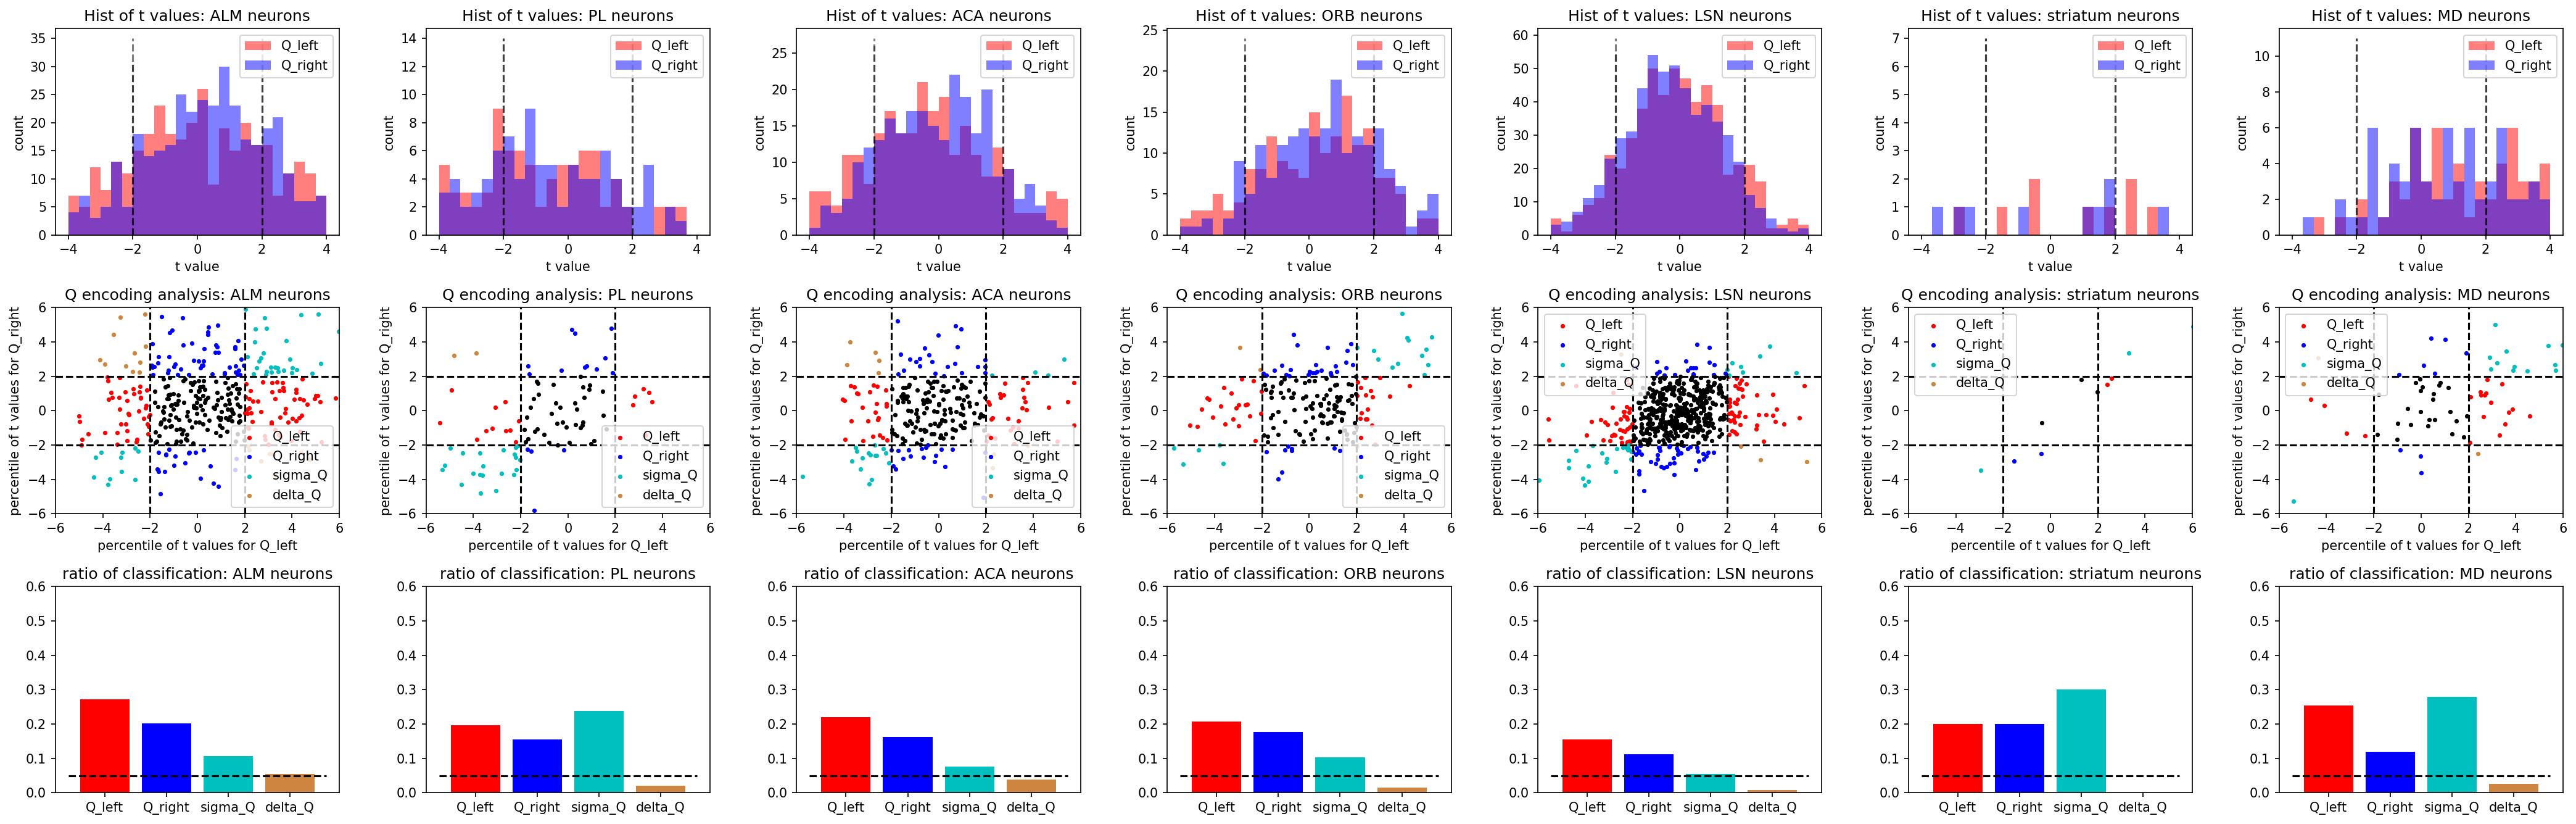

In [28]:
# plot std fit, single neuron encoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
percentiles_2_compute = [2.5, 97.5]

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b'}
hist_lim = (-4, 4)
# scatter plot
tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
dot_size = 6
# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*3), dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_encode_dict[region]
    tvalues_percentile = {'Q_left': None, 'Q_right': None}
    # histogram of regression tvalues
    row_ind = 0
    for i, q_side in enumerate(['Q_left', 'Q_right']):
        tvalues_q_side = df_fit[f'tvalues_{q_side}'].values
        tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
        tvalues_percentile[q_side] = tvalues_percentile_q_side
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                       color=colors[q_side], label=q_side, alpha=0.5)
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                     color='k', linestyle='--', alpha=0.5)
        #axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, hist_top, 
        #                             color=colors[q_side], linestyle='--', alpha=0.5)

    axs[row_ind, col_ind].set_title(f'Hist of t values: {region} neurons')
    axs[row_ind, col_ind].set_xlabel('t value')
    axs[row_ind, col_ind].set_ylabel('count')
    axs[row_ind, col_ind].legend()

    
    # scatter plot of neurons
    row_ind = 1
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    df_fit_Q_left_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_left_sig['tvalues_Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit[((df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_right_sig['tvalues_Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_sigma_Q_sig['tvalues_Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_delta_Q_sig['tvalues_Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit[(df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['tvalues_Q_left'].values, 
                                  df_fit_null['tvalues_Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {region} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind = 2
    
    print(f'{region} total dots: {len(df_fit)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit)),
        len(df_fit_Q_right_sig)/ float(len(df_fit)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.6)

plt.tight_layout()

In [1]:
# std fit, single neuron decoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
 
std_decode_columns = ['src_session', 'unit', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_dict = {region: pd.DataFrame(columns=std_decode_columns) for region in regions}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)

    df_Qs = q_latents[region]
    
    df_std_fit = df_std_decode_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            for unit in np.unique(neurons_region_session['unit'].values):
                fr = neurons_region_session[(neurons_region_session['unit']==unit)].iloc[0]['firing_rates']
                fr = sm.add_constant(fr)

                # fix this mismatch issue later
                if fr.shape[0] == X.shape[0]:
                    # decoding models: fr --> X
                    model = sm.OLS(X, fr)
                    results = model.fit()
                    df_std_fit.loc[len(df_std_fit.index)] = [session, unit, session, target_variable, results.f_pvalue]


NameError: name 'regions' is not defined

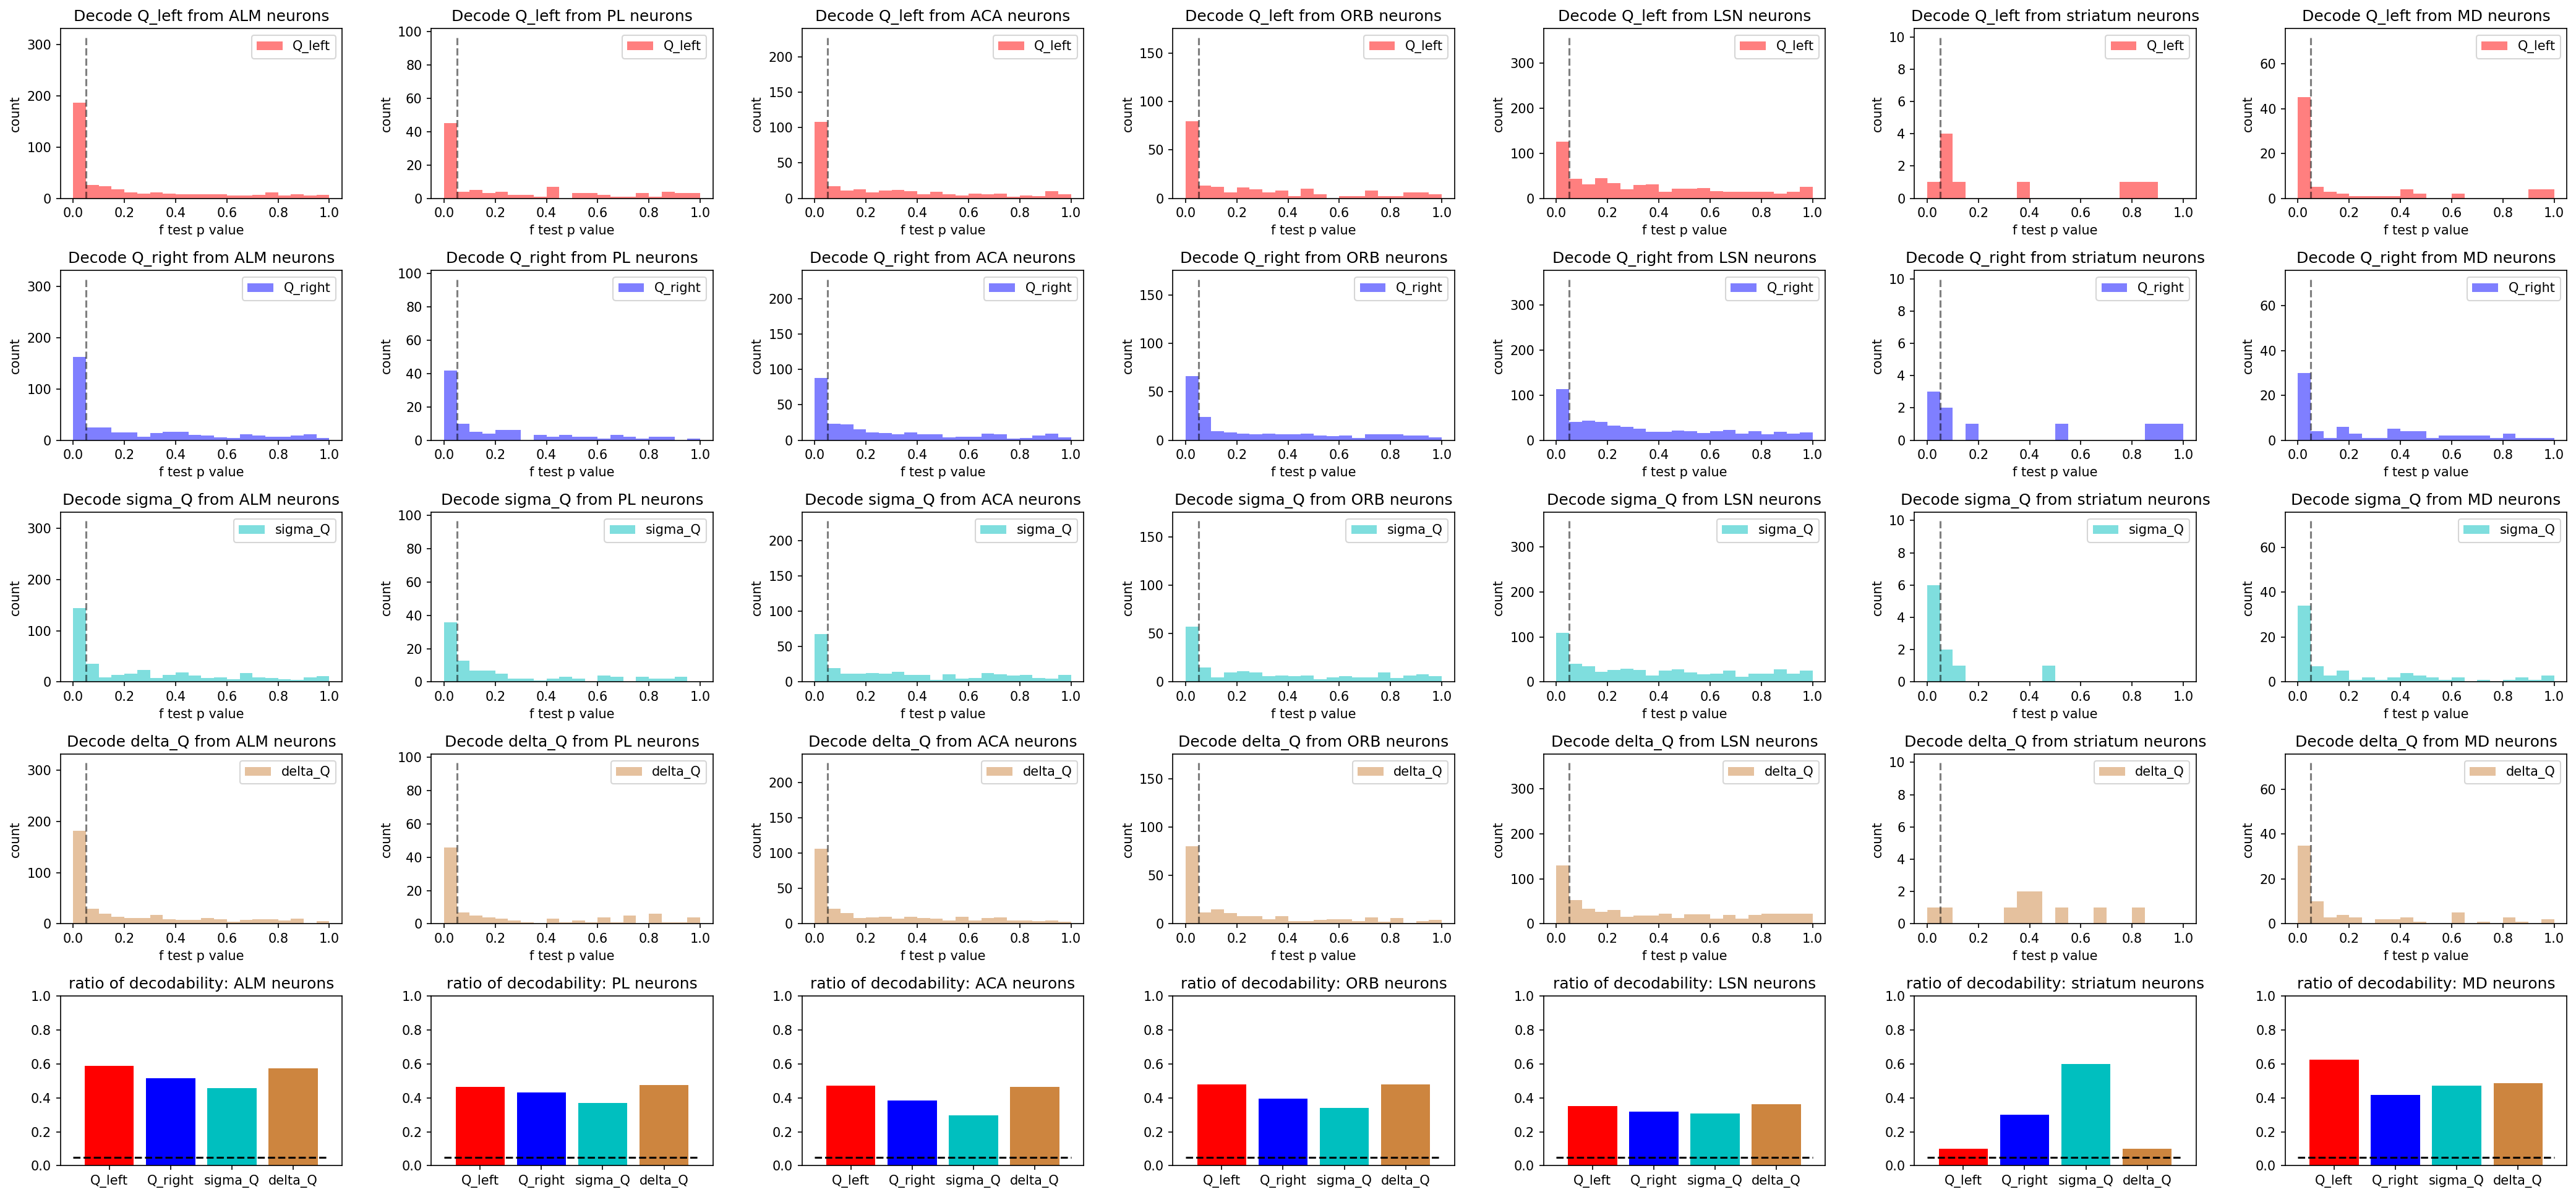

In [30]:
# plot std fit, single neuron decoding

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_decode_dict[region]
    n_unique_neurons = len(np.unique(df_fit['unit'].values))

    n_sig_neurons = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_unique_neurons, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_neurons[target_variable] = np.sum(ftest_pvalues < 0.05)

    
    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_neurons[target_variable]/ float(n_unique_neurons) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1)

plt.tight_layout()

In [51]:
# std fit, poppulation decoding
regions_to_fit = ['ALM', 'PL', 'ACA', 'ORB', 'LSN', 'striatum', 'MD']
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
 
std_decode_pop_columns = ['src_session', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_pop_dict = {region: pd.DataFrame(columns=std_decode_pop_columns) for region in regions}


# fit neurons from each region
for region in regions_to_fit:
    print(f'region {region}')
    neurons_region = neurons[region]
    sessions_with_unit = np.unique(neurons_region['session'].values)
    
    df_Qs = q_latents[region]
    df_std_fit = df_std_decode_pop_dict[region]

    for session in sessions_with_unit:
        neurons_region_session = neurons_region[neurons_region['session']==session]
        
        fr = np.empty((neurons_region_session.iloc[0]['firing_rates'].shape[0], 
                       len(neurons_region_session)))
        for j in range(len(neurons_region_session)):
            fr[:, j] = neurons_region_session.iloc[j]['firing_rates']
        fr = sm.add_constant(fr)
        print(f' sess {session} fr shape {fr.shape}')

        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        print(f' sess {session} df_Qs shape {df_Qs_session.shape}')
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            # fix this later
            if fr.shape[0] == X.shape[0]: 
                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                df_std_fit.loc[len(df_std_fit.index)] = [session, session, target_variable, results.f_pvalue]


region ALM
 sess 33 fr shape (586, 38)
 sess 33 df_Qs shape (586, 4)
 sess 34 fr shape (379, 108)
 sess 34 df_Qs shape (379, 4)
 sess 36 fr shape (450, 198)
 sess 36 df_Qs shape (450, 4)
 sess 37 fr shape (321, 55)
 sess 37 df_Qs shape (321, 4)
region PL
 sess 49 fr shape (748, 77)
 sess 49 df_Qs shape (749, 4)
 sess 50 fr shape (634, 49)
 sess 50 df_Qs shape (635, 4)
 sess 51 fr shape (594, 5)
 sess 51 df_Qs shape (594, 4)
 sess 52 fr shape (543, 94)
 sess 52 df_Qs shape (543, 4)
region ACA
 sess 33 fr shape (586, 4)
 sess 33 df_Qs shape (586, 4)
 sess 34 fr shape (379, 65)
 sess 34 df_Qs shape (379, 4)
 sess 36 fr shape (450, 137)
 sess 36 df_Qs shape (450, 4)
 sess 37 fr shape (321, 58)
 sess 37 df_Qs shape (321, 4)
 sess 43 fr shape (791, 25)
 sess 43 df_Qs shape (792, 4)
region ORB
 sess 46 fr shape (277, 155)
 sess 46 df_Qs shape (300, 4)
 sess 47 fr shape (421, 81)
 sess 47 df_Qs shape (421, 4)
 sess 48 fr shape (178, 65)
 sess 48 df_Qs shape (178, 4)
 sess 50 fr shape (272, 50)

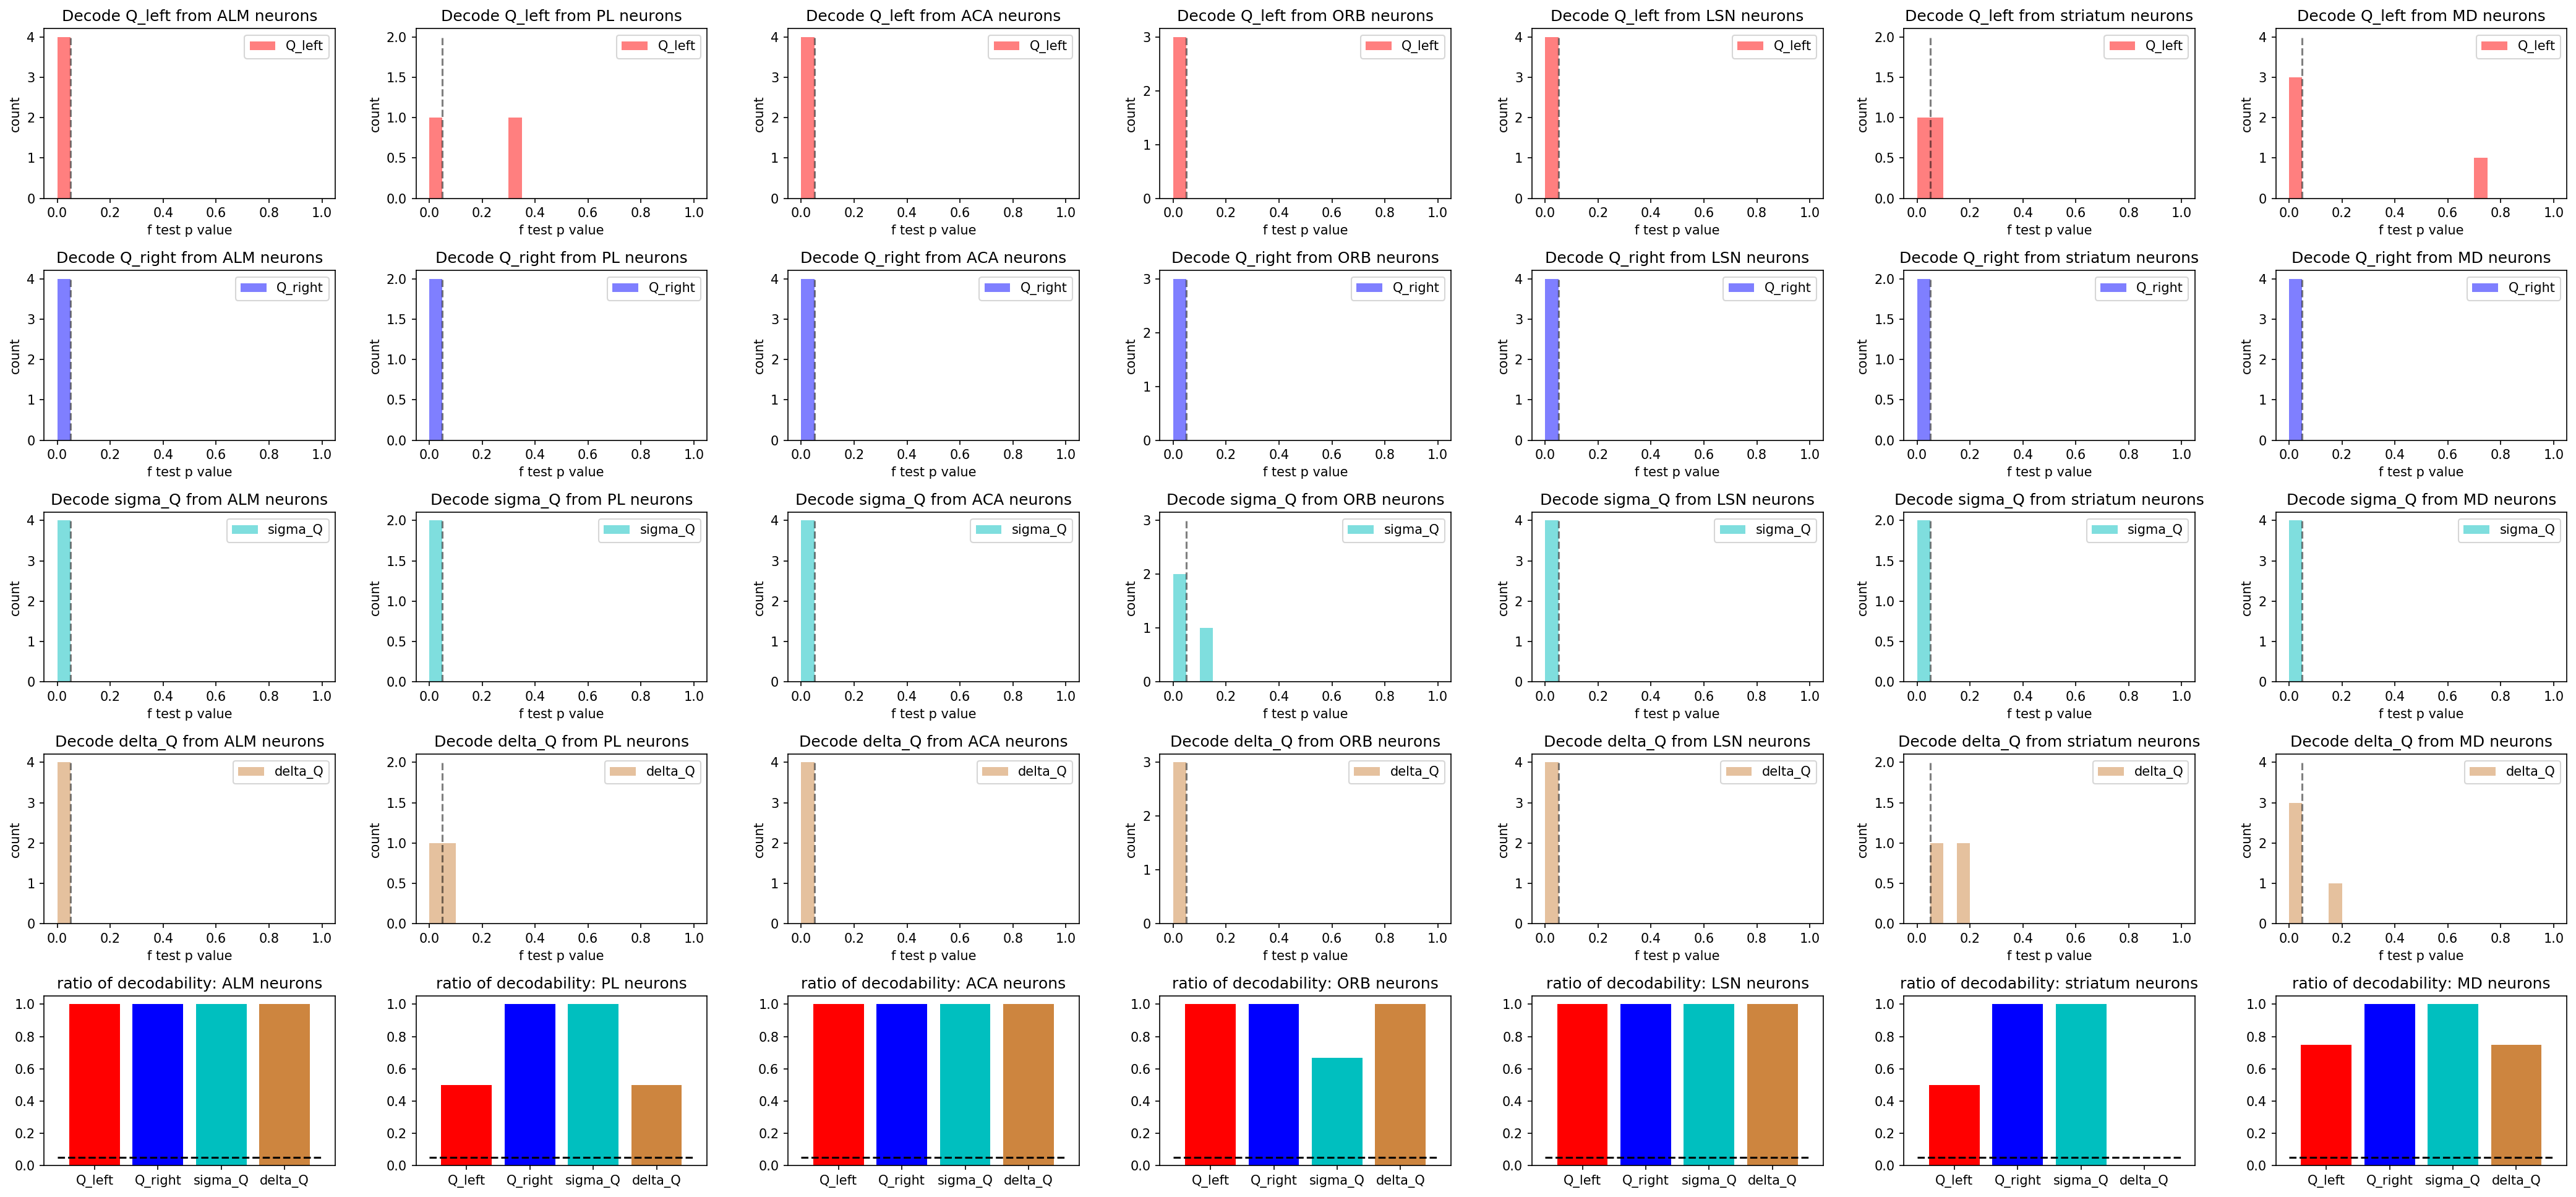

In [52]:
# plot std fit, poppulation decoding
# plot std fit, single neuron decoding

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(regions_to_fit), 
                        figsize=(4*len(regions_to_fit), 3*len(target_variables)+1),
                        dpi=150)
for region_id, region in enumerate(regions_to_fit):
    col_ind = region_id

    df_fit = df_std_decode_pop_dict[region]
    n_sessions = len(np.unique(df_fit['src_session'].values))

    n_sig_sessions = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_sessions, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {region} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_sessions[target_variable] = np.sum(ftest_pvalues < 0.05)

    
    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_sessions[target_variable]/ float(n_sessions) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {region} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1.05)

plt.tight_layout()

### multi-sessinon PERMUTATION analysis

In [ ]:
# msp fit, single neuron encoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# plot msp fit, single neuron encoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# msp fit, single neuron decoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# plot msp fit, single neuron decoding
# NOT AVAILABLE: no single neuron across sessions

In [ ]:
# msp fit, poppulation decoding

In [ ]:
# plot msp fit, poppulation decoding

### Pseudo-session analysis

In [ ]:
# ps fit, single neuron encoding

In [ ]:
# plot ps fit, single neuron encoding

In [ ]:
# ps fit, single neuron decoding

In [ ]:
# plot ps fit, single neuron decoding

In [ ]:
# ps fit, poppulation decoding

In [ ]:
# plot ps fit, poppulation decoding